## Imports

In [1]:
import os
import pydot
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, AveragePooling2D, DepthwiseConv2D, SeparableConv2D, Conv2D, BatchNormalization, ReLU, GlobalAveragePooling2D, Flatten, Dense, Flatten, Dropout, Lambda, Layer
from tensorflow.keras.models import Model
from contextlib import redirect_stdout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras import layers, Sequential, Model

### 1. MobileNet block
Next, we will build the *Mobilenet block* as a function that will
- take as input:
  - a tensor (**`x`**)
  - the number of filters for the Convolutional layer (**`filters`**)
  - the strides for the Depthwise Convolutional layer (**`strides`**)
- run:
    - apply a 3x3 *Depthwise Convolution layer* with **`strides`** strides followed by a *Batch Normalization* and a *ReLU* activation
    - apply a 1x1 *Convolution layer* with **`filters`** filters followed by a *Batch Normalization* and a *ReLU* activation
- return the tensor

and will return the tensor **`output`**.

In [2]:
def mobilenet_block(x, filters, strides):
    # depthwise convolution(filtering)
    x = DepthwiseConv2D(kernel_size=3, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    # 1 x 1 convolution (combining)
    x = Conv2D(filters=filters, kernel_size=1, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x
    

### 2) Lets Create MobileNet version 1

In [3]:
def mobilenet_v1(input_shape=None, num_classes=None):
    
    input_data = Input(shape=input_shape)
    
    # Simple convolution block
    x = Conv2D(filters=32, kernel_size=3, strides=2, padding='same')(input_data)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # mobilenet blocks
    x = mobilenet_block(x, filters=64, strides=1)

    x = mobilenet_block(x, filters=128, strides=2)
    x = mobilenet_block(x, filters=128, strides=1)


    x = mobilenet_block(x, filters=256, strides=2)
    x = mobilenet_block(x, filters=256, strides=1)


    x = mobilenet_block(x, filters=512, strides=2)
    for _ in range(5):
        x = mobilenet_block(x, filters=512, strides=1)
        
    x = mobilenet_block(x, filters=1024, strides=2)
    x = mobilenet_block(x, filters=1024, strides=1)

    x = GlobalAveragePooling2D()(x)
    x = Dense(1024,activation='relu')(x)
    x = Dense(512,activation='relu')(x)
    preds = Dense(num_classes ,activation='softmax')(x) 

    model = Model(inputs=input_data, outputs=preds, name='MobileNet_V1')

    return model


### 3) Summary of a model

In [159]:
def summary(output=None, target=None, model = None):
        """ Show / Save model structure (summary) """
        if model is not None:
            model.summary()
            if target is not None:
                os.makedirs(output, exist_ok=True)
                with open(os.path.join(output, target), "w") as f:
                    with redirect_stdout(f):
                        model.summary()

In [160]:
model = mobilenet_v1(input_shape=(224, 224, 3), num_classes=1000)
summary(output= './summary', target='summary_V1', model = model)

Model: "MobileNet_V1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_338 (Conv2D)          (None, 112, 112, 32)      896       
_________________________________________________________________
batch_normalization_648 (Bat (None, 112, 112, 32)      128       
_________________________________________________________________
re_lu_648 (ReLU)             (None, 112, 112, 32)      0         
_________________________________________________________________
depthwise_conv2d_312 (Depthw (None, 112, 112, 32)      320       
_________________________________________________________________
batch_normalization_649 (Bat (None, 112, 112, 32)      128       
_________________________________________________________________
re_lu_649 (ReLU)             (None, 112, 112, 32)     

In [2]:
def model_plot(model = None, file_name=None):
    if model and file_name is not None:
        print('Model plotting...')
        
        plot_model(model, to_file = file_name, show_shapes=True,
                   show_layer_names=True,
                   rankdir='LB', expand_nested=True, dpi=96)
        print('Model plotted..')

In [162]:
model_plot(model = model, file_name='MobileNet_V1.png')

Model plotting...
Model plotted..


### 4) Data Preparation

In [30]:
TRAINING_DATA_DIRECTORY = './dataset/train/'
"""
VALIDATION_DATA_DIRECTORY = './dataset/valid/'
TESTING_DATA_DIRECTORY = './dataset/test/'
"""

"\nVALIDATION_DATA_DIRECTORY = './dataset/valid/'\nTESTING_DATA_DIRECTORY = './dataset/test/'\n"

In [31]:
train_data_generator = ImageDataGenerator(rescale=1./255)

"""
validation_data_generator = ImageDataGenerator(rescale=1./255)

testing_data_generator = ImageDataGenerator(rescale=1./255)
"""
training_generator = train_data_generator.flow_from_directory(
            TRAINING_DATA_DIRECTORY,
            target_size=(224, 224),
            batch_size=32,
            class_mode='categorical'
)



"""
validation_generator = validation_data_generator.flow_from_directory(
            VALIDATION_DATA_DIRECTORY,
            target_size=(224, 224),
            batch_size=32,
            class_mode='categorical'
)

testing_generator = testing_data_generator.flow_from_directory(
            TESTING_DATA_DIRECTORY,
            target_size=(224, 224),
            batch_size=32,
            class_mode='categorical'
)
"""

Found 1376 images belonging to 2 classes.


"\nvalidation_generator = validation_data_generator.flow_from_directory(\n            VALIDATION_DATA_DIRECTORY,\n            target_size=(224, 224),\n            batch_size=32,\n            class_mode='categorical'\n)\n\ntesting_generator = testing_data_generator.flow_from_directory(\n            TESTING_DATA_DIRECTORY,\n            target_size=(224, 224),\n            batch_size=32,\n            class_mode='categorical'\n)\n"

### 5) Data Visualization

(32, 2)
[0. 1.]


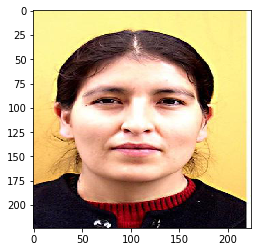

In [32]:
image_batch, label_batch = next(iter(training_generator))  # 0 -> autistic 1 -> non-autistic
print(label_batch.shape)
for i in range(len(image_batch) - 1, len(image_batch)):
    image = image_batch[i]
    print(label_batch[i])
    plt.imshow(image)
    plt.show()

### 6) Train the model

In [166]:
model = mobilenet_v1(input_shape=(224, 224, 3), num_classes=2)

In [167]:
model.compile(optimizer='adam', loss ='categorical_crossentropy', metrics=['accuracy'])

In [169]:
#model.fit(training_generator, epochs=1, validation_data=validation_generator,
 #         steps_per_epoch=2536//32, shuffle=True, 
  #        validation_steps=100//32)

### 7) Transfer Learning

In [7]:
model = tf.keras.applications.MobileNet(weights='imagenet',include_top=False, input_shape=(224, 224, 3))

for layer in model.layers:
    layer.trainable=False

In [8]:
x = model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024,activation='relu')(x)
x = Dropout(0.5)(x)
x=Dense(512,activation='relu')(x)
x = Dropout(0.5)(x)
preds=Dense(2,activation='softmax')(x) 

In [9]:
model = Model(inputs=model.input,outputs=preds)

In [10]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [182]:
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_39 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128 

In [11]:
model.fit(training_generator, epochs=10, validation_data=validation_generator,
          steps_per_epoch=2536//32, shuffle=True, 
          validation_steps=100//32)

Epoch 1/10
79/79 [==============================] - 117s 1s/step - loss: 0.7402 - accuracy: 0.6573 - val_loss: 0.4714 - val_accuracy: 0.7812
Epoch 2/10
79/79 [==============================] - 90s 1s/step - loss: 0.4958 - accuracy: 0.7547 - val_loss: 0.4764 - val_accuracy: 0.8125
Epoch 3/10
79/79 [==============================] - 84s 1s/step - loss: 0.4544 - accuracy: 0.7776 - val_loss: 0.4533 - val_accuracy: 0.8021
Epoch 4/10
79/79 [==============================] - 75s 947ms/step - loss: 0.4367 - accuracy: 0.7911 - val_loss: 0.4622 - val_accuracy: 0.8125
Epoch 5/10
79/79 [==============================] - 95s 1s/step - loss: 0.3920 - accuracy: 0.8179 - val_loss: 0.4603 - val_accuracy: 0.8229
Epoch 6/10
79/79 [==============================] - 89s 1s/step - loss: 0.3827 - accuracy: 0.8231 - val_loss: 0.3987 - val_accuracy: 0.8438
Epoch 7/10
79/79 [==============================] - 90s 1s/step - loss: 0.3743 - accuracy: 0.8271 - val_loss: 0.4418 - val_accuracy: 0.7917
Epoch 8/10
79/79

In [12]:
model.save('autism_mobilenet_v1_10epochs.h5')

In [17]:
#print("Evaluate on test data")
#results = model.evaluate(testing_generator, batch_size=32)
#print("test loss, test acc:", results)

## Alternative approach

In [11]:
def MobilenetV1(input_shape, k, alpha=1, shallow=False):
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = Conv2D(filters=32 * alpha, kernel_size=(3, 3), strides=(2, 2), padding="same", activation="relu")(inputs)
    x = SeparableConv2D(filters=64 * alpha, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu")(x)
    x = SeparableConv2D(filters=128 * alpha, kernel_size=(3, 3), strides=2, padding="same", activation="relu")(x)
    x = SeparableConv2D(filters=128 * alpha, kernel_size=(3, 3), strides=1, padding="same", activation="relu")(x)
    x = SeparableConv2D(filters=256 * alpha, kernel_size=(3, 3), strides=2, padding="same", activation="relu")(x)
    x = SeparableConv2D(filters=256 * alpha, kernel_size=(3, 3), strides=1, padding="same", activation="relu")(x)
    x = SeparableConv2D(filters=512 * alpha, kernel_size=(3, 3), strides=2, padding="same", activation="relu")(x)

    if not shallow:
        x = SeparableConv2D(filters=512 * alpha, kernel_size=(3, 3), strides=1, padding="same", activation="relu")(x)
        x = SeparableConv2D(filters=512 * alpha, kernel_size=(3, 3), strides=1, padding="same", activation="relu")(x)
        x = SeparableConv2D(filters=512 * alpha, kernel_size=(3, 3), strides=1, padding="same", activation="relu")(x)
        x = SeparableConv2D(filters=512 * alpha, kernel_size=(3, 3), strides=1, padding="same", activation="relu")(x)
        x = SeparableConv2D(filters=512 * alpha, kernel_size=(3, 3), strides=1, padding="same", activation="relu")(x)

    x = SeparableConv2D(filters=1024 * alpha, kernel_size=(3, 3), strides=2, padding="same", activation="relu")(x)
    x = SeparableConv2D(filters=1024 * alpha, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu")(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(1024,activation='relu')(x)
    x = Dense(512,activation='relu')(x)
    output = Dense(units=k, activation="softmax")(x)

    model = Model(inputs=inputs, outputs=output)

    return model

In [12]:
model = MobilenetV1(input_shape=(224, 224, 3), k=2)

In [13]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 32)      896       
_________________________________________________________________
separable_conv2d_26 (Separab (None, 112, 112, 64)      2400      
_________________________________________________________________
separable_conv2d_27 (Separab (None, 56, 56, 128)       8896      
_________________________________________________________________
separable_conv2d_28 (Separab (None, 56, 56, 128)       17664     
_________________________________________________________________
separable_conv2d_29 (Separab (None, 28, 28, 256)       34176     
_________________________________________________________________
separable_conv2d_30 (Separab (None, 28, 28, 256)       6809

In [14]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [19]:
#model.fit(training_generator, epochs=10, validation_data=validation_generator,
 #         steps_per_epoch=2536//32, shuffle=True, 
  #        validation_steps=100//32)

## MobileNet V1 Using Custom subclassing

In [3]:
class MobileNet(Model):
    def __init__(self, num_classes, alpha=1, input_shape=(224, 224, 3)):
        super(MobileNet, self).__init__()

        self.conv1 = Sequential([
            Input(input_shape),
            Conv2D(32,(3, 3),
                      strides=2,
                      padding='same',
                      activation='relu'),
            SeparableConv2D(64,
                               (3, 3),
                               strides=1,
                               padding="same",
                               depth_multiplier=alpha,
                               activation='relu')
        ])
        self.conv2 = Sequential([
            SeparableConv2D(128,
                               (3, 3),
                               strides=1,
                               padding="same",
                               depth_multiplier=alpha,
                               activation='relu'),
            SeparableConv2D(128,
                               (3, 3),
                               strides=1,
                               padding="same",
                               depth_multiplier=alpha,
                               activation='relu')
        ])
        self.conv3 = Sequential([
            SeparableConv2D(1256,
                               (3, 3),
                               strides=1,
                               padding="same",
                               depth_multiplier=alpha,
                               activation='relu'),
            SeparableConv2D(256,
                               (3, 3),
                               strides=1,
                               padding="same",
                               depth_multiplier=alpha,
                               activation='relu'),
        ])
        self.conv4 = Sequential([
            SeparableConv2D(512,
                               (3, 3),
                               strides=1,
                               padding="same",
                               depth_multiplier=alpha,
                               activation='relu'),
            SeparableConv2D(512,
                               (3, 3),
                               strides=1,
                               padding="same",
                               depth_multiplier=alpha,
                               activation='relu'),
            SeparableConv2D(512,
                               (3, 3),
                               strides=1,
                               padding="same",
                               depth_multiplier=alpha,
                               activation='relu'),
            SeparableConv2D(512,
                               (3, 3),
                               strides=1,
                               padding="same",
                               depth_multiplier=alpha,
                               activation='relu'),
            SeparableConv2D(512,
                               (3, 3),
                               strides=1,
                               padding="same",
                               depth_multiplier=alpha,
                               activation='relu'),
            SeparableConv2D(512,
                               (3, 3),
                               strides=1,
                               padding="same",
                               depth_multiplier=alpha,
                               activation='relu'),
        ])
        self.conv5 = Sequential([
            SeparableConv2D(1024,
                               (3, 3),
                               strides=1,
                               padding="same",
                               depth_multiplier=alpha,
                               activation='relu'),
            SeparableConv2D(1024,
                               (3, 3),
                               strides=1,
                               padding="same",
                               depth_multiplier=alpha,
                               activation='relu'),
        ])
        self.ap = layers.AveragePooling2D((7, 7), strides=1)
        self.flat = layers.Flatten()
        self.fc = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs, training=False):
        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.ap(x)
        x = self.flat(x)
        x = self.fc(x)
        return x


def mobilenet(num_classes, input_shape):
    return MobileNet(num_classes, input_shape=input_shape)


In [11]:
model = mobilenet(10, (32, 32, 3))

In [31]:
#model.build(input_shape=(None, 224, 224, 3))

In [33]:
#model.summary()

In [2]:
cifar10 = tf.keras.datasets.cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices(
    (x_test, y_test)).batch(32)

In [6]:
loss_object = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(
    name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(
    name='test_accuracy')

In [7]:
# @tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss)
    train_accuracy(labels, predictions)


# @tf.function
def test_step(images, labels):
    predictions = model(images)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [8]:
"""
epochs = 1
for epoch in range(epochs):
    for images, labels in train_ds:
        train_step(images, labels)

    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)

    template = 'Epoch: [{}/{}], Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print(template.format(epoch+1,
                          epochs,
                          train_loss.result(),
                          train_accuracy.result()*100,
                          test_loss.result(),
                          test_accuracy.result()*100))
    # wandb.log({
    #     "TrainLoss": train_loss.result(),
    #     "TestLoss": test_loss.result(),
    #     "TrainAcc": train_accuracy.result()*100,
    #     "TestAcc": test_accuracy.result()*100
    # })
    train_loss.reset_states()
    test_loss.reset_states()
    train_accuracy.reset_states()
    test_accuracy.reset_states()
"""

'\nepochs = 1\nfor epoch in range(epochs):\n    for images, labels in train_ds:\n        train_step(images, labels)\n\n    for test_images, test_labels in test_ds:\n        test_step(test_images, test_labels)\n\n    template = \'Epoch: [{}/{}], Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}\'\n    print(template.format(epoch+1,\n                          epochs,\n                          train_loss.result(),\n                          train_accuracy.result()*100,\n                          test_loss.result(),\n                          test_accuracy.result()*100))\n    # wandb.log({\n    #     "TrainLoss": train_loss.result(),\n    #     "TestLoss": test_loss.result(),\n    #     "TrainAcc": train_accuracy.result()*100,\n    #     "TestAcc": test_accuracy.result()*100\n    # })\n    train_loss.reset_states()\n    test_loss.reset_states()\n    train_accuracy.reset_states()\n    test_accuracy.reset_states()\n'

In [12]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [14]:
#model.fit(train_ds, epochs=2, validation_data=test_ds, batch_size=32)

## MobileNet V2

In [4]:
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import DepthwiseConv2D
from tensorflow.keras.layers import Add
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from keras import backend as K

Using TensorFlow backend.


### 1) ReLU6

In [5]:
def relu6(x):
  return K.relu(x, max_value=6.0)

### 2) Convolution operation

In [6]:
def _conv2d(inputs, filters, kernel_size, strides):
    '''This function defines a 2D convolution operation with BN and relu6.
    '''
    channel_axis = 1 if K.image_data_format == "channels_first" else -1

    x = Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding='same')(inputs)
    x = BatchNormalization(axis=channel_axis)(x)
    return Activation(relu6)(x)


### 3) Bottleneck 

In [7]:
def _bottleneck(inputs, filters, kernel_size, strides, t, r, alpha=1):
    '''This function defines a linear bottleneck structure.
    '''

    channel_axis = 1 if K.image_data_format == "channels_first" else -1

    up_channel = K.int_shape(inputs)[1] * t if K.image_data_format == "channels_first" else K.int_shape(inputs)[-1] * t

    down_channel = filters * alpha

    x = _conv2d(inputs=inputs, filters=up_channel, kernel_size=(1, 1), strides=(1, 1))

    x = DepthwiseConv2D(kernel_size=kernel_size, strides=strides, padding='same', depth_multiplier=1)(x)
    x = BatchNormalization(axis=channel_axis)(x)
    x = Activation(relu6)(x)

    x = Conv2D(filters=down_channel, kernel_size=(1, 1), strides=(1, 1), padding='same')(x)

    if r:
        x = Add()([inputs, x])

    return x

### 4) Inverted residual block

In [8]:
def _inverted_residual_block(inputs, filters, kernel_size, strides, t, n, alpha=1, r=False):
    x = _bottleneck(inputs, filters, kernel_size, strides, t, False, alpha)
    for _ in range(1, n):
        x = _bottleneck(x, filters, kernel_size, 1, t, True, alpha)

    return x

### 5) Model

In [38]:
def MobilenetV2(input_shape, k, alpha=1):
    '''This function defines a mobilenetv2 architecture.
    Args:
    input_shape:input shape of the model.
    k:number of class.
    alpha:width multiplier,in [0.50, 0.75, 1.0]
    Returns:
    MobileNetv2 model.
    '''

    inputs = Input(shape=input_shape)

    x = _conv2d(inputs, filters=32 * alpha, kernel_size=3, strides=2)
    x = _inverted_residual_block(inputs=x, filters=16, kernel_size=3, strides=1, t=1, n=1)
    x = _inverted_residual_block(inputs=x, filters=24, kernel_size=3, strides=2, t=6, n=2)
    x = _inverted_residual_block(inputs=x, filters=32, kernel_size=3, strides=2, t=6, n=3)
    x = _inverted_residual_block(inputs=x, filters=64, kernel_size=3, strides=2, t=6, n=4)
    x = _inverted_residual_block(inputs=x, filters=96, kernel_size=3, strides=1, t=6, n=3)
    x = _inverted_residual_block(inputs=x, filters=160, kernel_size=3, strides=2, t=6, n=3)
    x = _inverted_residual_block(inputs=x, filters=320, kernel_size=3, strides=1, t=6, n=1)
    x = _conv2d(inputs=x, filters=1280 * alpha, kernel_size=(1, 1), strides=1)
    x = AveragePooling2D(pool_size=(7, 7))(x)
    x = Flatten(name="flatten")(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(2, activation="softmax")(x)

    model = Model(inputs=inputs, outputs=x)
    
    return model

In [39]:
mobilenetv2 = MobilenetV2((224, 224, 3), k=2)

In [40]:
mobilenetv2.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_37 (Conv2D)              (None, 112, 112, 32) 896         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 112, 112, 32) 128         conv2d_37[0][0]                  
__________________________________________________________________________________________________
activation_36 (Activation)      (None, 112, 112, 32) 0           batch_normalization_36[0][0]     
____________________________________________________________________________________________

In [13]:
model_plot(model = mobilenetv2, file_name='MobileNet_V2.png')

Model plotting...
Model plotted..


### Transfer learning

In [24]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam

In [15]:
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

9412608/9406464 [==============================] - 6s 1us/step


In [16]:
model = baseModel.output

In [17]:
model = AveragePooling2D(pool_size=(7, 7))(model)
model = Flatten(name="flatten")(model)
model = Dense(128, activation="relu")(model)
model = Dropout(0.5)(model)
model = Dense(2, activation="softmax")(model)

In [18]:
for layer in baseModel.layers:
	layer.trainable = False


In [20]:
model = Model(inputs=baseModel.input, outputs=model)

In [21]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
____________________________________________________________________________________________

In [22]:
INITIAL_LR = 1e-4
EPOCHS = 20
BATCH = 32

In [25]:
opt = Adam(lr=INITIAL_LR, decay=INITIAL_LR / EPOCHS)

In [33]:
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

### Data Preproccessing

In [34]:
model.fit(training_generator, epochs=10,steps_per_epoch=1376//32, shuffle=True)

Epoch 1/10
43/43 [==============================] - 38s 894ms/step - loss: 0.3627 - accuracy: 0.8547
Epoch 2/10
43/43 [==============================] - 36s 829ms/step - loss: 0.0936 - accuracy: 0.9717
Epoch 3/10
43/43 [==============================] - 38s 886ms/step - loss: 0.0549 - accuracy: 0.9797
Epoch 4/10
43/43 [==============================] - 39s 903ms/step - loss: 0.0436 - accuracy: 0.9840
Epoch 5/10
43/43 [==============================] - 38s 894ms/step - loss: 0.0334 - accuracy: 0.9884
Epoch 6/10
43/43 [==============================] - 37s 863ms/step - loss: 0.0243 - accuracy: 0.9942
Epoch 7/10
43/43 [==============================] - 37s 857ms/step - loss: 0.0223 - accuracy: 0.9927
Epoch 8/10
43/43 [==============================] - 39s 912ms/step - loss: 0.0160 - accuracy: 0.9956
Epoch 9/10
43/43 [==============================] - 39s 918ms/step - loss: 0.0156 - accuracy: 0.9971
Epoch 10/10
43/43 [==============================] - 39s 908ms/step - loss: 0.0125 - accura

In [35]:
model.save('mask_detector_mobilenetv2_transfer_learning.h5')